# Machine Learning Nanodegree - Capstone Project
### Starbuck Awards Program Analysis
The problem statement is to predict wheter customer will accept to an offer from given demographics informations and type of campaign (BOGO, discount etc.).

**The problem will be Binary Classification** <br/>
Postive class : customer accept the offer (1) <br/>
Negative class : customer do not accept the offer (0)

In [1]:
import pandas as pd
import numpy as np
import json
import math

import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

from sklearn.preprocessing import LabelEncoder


!jt -t onedork

In [2]:
portfolio = pd.read_json('Dataset/portfolio.json', orient = 'records', lines = True)
profile = pd.read_json('Dataset/profile.json', orient = 'records', lines = True)
transcript = pd.read_json('Dataset/transcript.json', orient = 'records', lines = True)

# Data Preparation
## Portfolio
Portfolio dataset contain informations about campaign informations that sent customers.

In [3]:
print(f'Portfolio have {portfolio.shape[0]} rows and {portfolio.shape[1]} columns')
portfolio

Portfolio have 10 rows and 6 columns


,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


### Data Cleaning

1. Split the `channel` column in to 4 columns for further data modelling.<br/>
*Email, Mobile, Social, Web*
2. Perform one-hot encoder for `offer_type`

In [4]:
# Create onehot columns for channels by extract string and joining with | symbols
channel_onehot = portfolio['channels'].str.join('|').str.get_dummies().add_prefix('channel_')

# Join channel_onehot into main dataset and drop the origial channels column
portfolio = portfolio.join(channel_onehot)
portfolio.drop(['channels'], axis = 1, inplace = True)

In [5]:
# Transform offer_type into one-hot columns
portfolio = portfolio.join(pd.get_dummies(portfolio.pop('offer_type')).add_prefix('offer_type_'))

# Rename columns 
portfolio.rename(columns = {'id':'offer_id'}, inplace = True)

In [6]:
portfolio

,reward,difficulty,duration,offer_id,channel_email,channel_mobile,channel_social,channel_web,offer_type_bogo,offer_type_discount,offer_type_informational
0,10,10,7,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0,1,0,0
1,10,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,1,0,0
2,0,0,4,3f207df678b143eea3cee63160fa8bed,1,1,0,1,0,0,1
3,5,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1,1,0,0
4,5,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1,0,1,0
5,3,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1,0,1,0
6,2,10,10,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1,0,1,0
7,0,0,3,5a8bc65990b245e5a138643cd4eb9837,1,1,1,0,0,0,1
8,5,5,5,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1,1,0,0
9,2,10,7,2906b810c7d4411798c6938adc9daaa5,1,1,0,1,0,1,0


## Profile
Profile dataset contain demographic information for each customer on rewards program.

In [7]:
print(f'Profile have {profile.shape[0]} rows and {profile.shape[1]} columns')
profile.head(10)

Profile have 17000 rows and 5 columns


,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
5,M,68,e2127556f4f64592b11af22de27a7932,20180426,70000.0
6,None,118,8ec6ce2a7e7949b1bf142def7d0e0586,20170925,NaN
7,None,118,68617ca6246f4fbc85e91a2a49552598,20171002,NaN
8,M,65,389bc3fa690240e798340f5a15918d5c,20180209,53000.0
9,None,118,8974fc5686fe429db53ddde067b88302,20161122,NaN


On profile dataset, we do not have any duplicate customer_id. Total customer_id is 17,000 users

In [8]:
print('Number of unique customer id ', len(profile['id'].unique()))

Number of unique customer id  17000


### Data Cleaning

Convert `became_member_on` to datetime format. <br/>
Create `became_member_on_long` as how long user became member compare with current date<br/>
Exract `year` and `month` of becoming the member on reward application

In [9]:
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format = '%Y%m%d')
profile['became_member_on_long'] = (pd.to_datetime('today') - pd.to_datetime(profile['became_member_on'], format = '%Y%m%d')).astype('timedelta64[D]').astype(int)

profile['start_year'] = profile.became_member_on.dt.year
profile['start_month'] = profile.became_member_on.dt.month

In [10]:
profile.drop('became_member_on', axis = 1, inplace = True)
profile.sort_values('became_member_on_long', ascending = False)

,gender,age,id,income,became_member_on_long,start_year,start_month
8948,M,64,77388a70eaf14433b4efc5d01fa947bf,69000.0,2536,2013,7
569,M,36,dbb4766b7dd94ca2b83a855312a3ebe9,74000.0,2535,2013,7
1200,M,52,5ffdab087e674149a89324a732b4f993,65000.0,2535,2013,7
7796,F,58,d25f38519a89455499c9e49e67ae1511,55000.0,2535,2013,7
10933,F,67,7b42b5bbe237406aaf2748a09050f745,58000.0,2534,2013,7
...,...,...,...,...,...,...,...
12560,F,49,464738f7360847adb55de84c859ba8af,50000.0,713,2018,7
10282,M,46,e4989ca3d8974e28a3fe87aa0b0ce327,74000.0,713,2018,7
8152,F,48,fb75504a0e404549995a3e8427a2a252,64000.0,713,2018,7
1517,M,28,267e47de94fd46b1afa96dea1c9d3cbf,33000.0,713,2018,7


#### Check missing value
Find out that `Gender` and `Income` have missing on the same positions with some reason.

In [11]:
profile.isna().mean()*100

gender                   12.794118
age                       0.000000
id                        0.000000
income                   12.794118
became_member_on_long     0.000000
start_year                0.000000
start_month               0.000000
dtype: float64

Visually check the missing data in form of matrix by sort age.
- Found that all missing value of `income` and `gender` occur together.
- `age` for these missing value is all same value 118 <br/>
From these findings and amount of missing data, all NaN will be dropped.

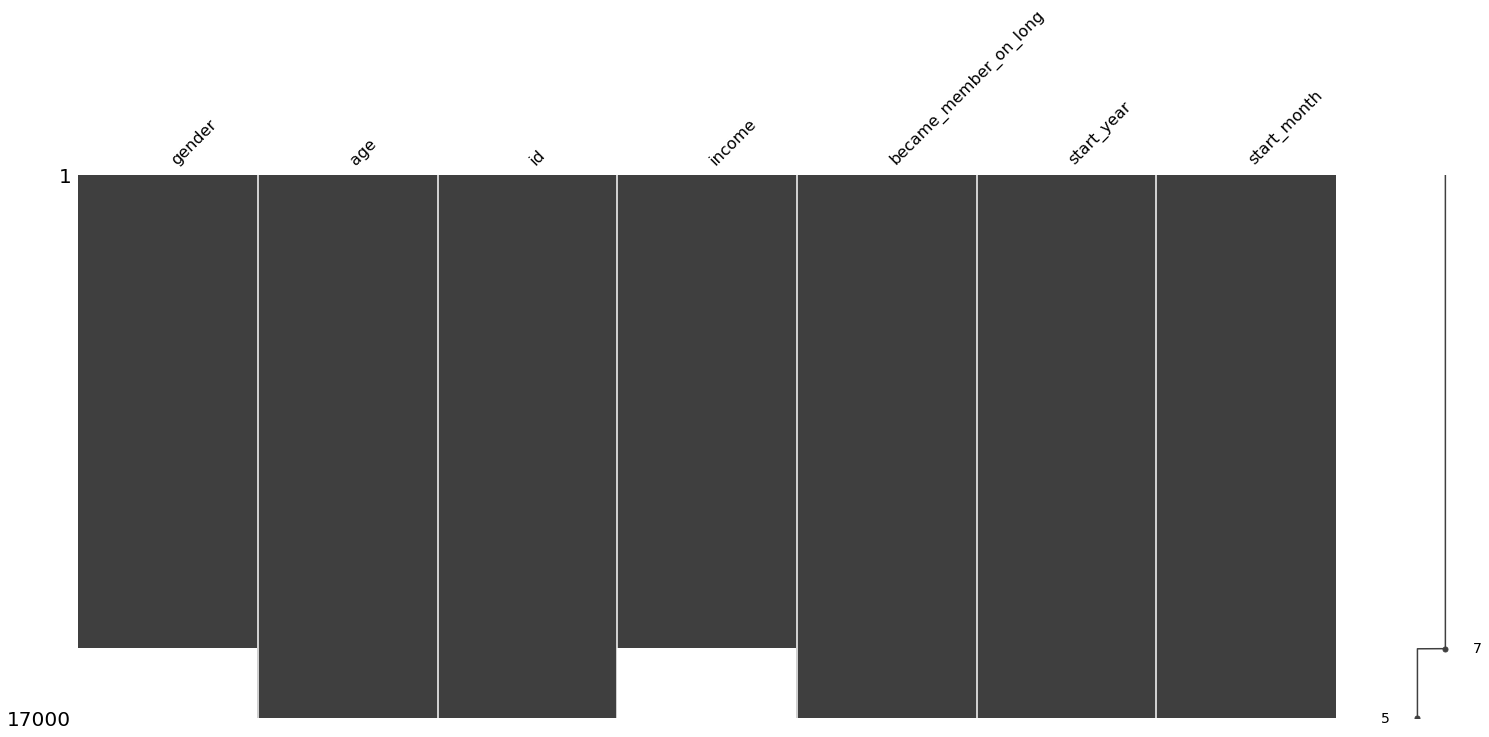

In [12]:
%matplotlib inline
msno.matrix(profile.sort_values(by = 'age'))

In [13]:
profile[profile['age'] == 118].sample(10)

,gender,age,id,income,became_member_on_long,start_year,start_month
2727,None,118,7e000dcb51f84ee2809f728294e5b92c,NaN,1043,2017,8
13285,None,118,f38a220042de4c90a5f967ef6c4403d5,NaN,1236,2017,2
12631,None,118,66bacac758ea46f7a08baea5a463ee27,NaN,1093,2017,7
5762,None,118,d09c99f76c7d4fbf9fc7ae5c833f3e38,NaN,1355,2016,10
8298,None,118,31bf20236dda4f92b15153c439352a25,NaN,821,2018,4
36,None,118,4beeb3ed64dd4898b0edf2f6b67426d3,NaN,1462,2016,7
14414,None,118,7ebc1c5f8180493f91077a3aaf37167a,NaN,1139,2017,5
16297,None,118,40abb553ffed4b1aa69d65c96fc0d5a8,NaN,1047,2017,8
4007,None,118,1b13f0dc7eca4451bf9dc1454140846f,NaN,1726,2015,10
842,None,118,312b2643dbd24597b1a9c45a84a29527,NaN,1775,2015,8


In [14]:
# Drop na in any positions
profile.dropna(how = 'any', axis = 0 ,inplace = True)

# Check amount of missing value after delete NaN in dataframe
profile.isna().mean()*100

gender                   0.0
age                      0.0
id                       0.0
income                   0.0
became_member_on_long    0.0
start_year               0.0
start_month              0.0
dtype: float64

Create new column 'loyalty_type' base on duration of becoming member. <br/>
*new*, *regular*, *loyalty*

In [15]:
profile['loyalty_type'] = pd.cut(profile['became_member_on_long'], 
                                  bins = [350, 1000,
                                          1700, 2600],
                                  labels = ['new', 'regular', 'loyalty']).astype(str)
profile.drop('became_member_on_long', axis = 1, inplace = True)
profile['loyalty_type'].value_counts()

regular    6988
new        5686
loyalty    2151
Name: loyalty_type, dtype: int64

Create new column 'income' base on duration of becoming member. <br/>
*medium*, *above-medium*, *high*

In [16]:
# Create income_grougp as a categorical of income
profile['income_group'] = pd.cut(profile['income'], 
                                    bins=[28000, 60000, 90000, 130000],
                                    labels=['medium', 'above-medium', 'high']).astype(str)

profile.drop('income', axis = 1, inplace = True)
profile['income_group'].value_counts()

medium          6693
above-medium    5938
high            2194
Name: income_group, dtype: int64

In [17]:
# Create age_group as a categorical of age
profile['age_group'] = pd.cut(profile['age'], 
                                    bins=[15, 23, 40, 65, 105],
                                    labels=['teen', 'young-adult', 'adult', 'elderly']).astype(str)

profile.drop('age', axis = 1, inplace = True)
profile['age_group'].value_counts()

adult          7537
elderly        3986
young-adult    2565
teen            737
Name: age_group, dtype: int64

Perform label encoder on `gender`, `age_group` and `loyalty_type`columns

In [18]:
# Use label endcoder on all new generated categorical columns
le = LabelEncoder()

profile['gender'] = le.fit_transform(profile['gender'])
profile['age_group'] = le.fit_transform(profile['age_group'])
profile['loyalty_type'] = le.fit_transform(profile['loyalty_type'])
profile['income_group'] = le.fit_transform(profile['income_group'])

In [19]:
profile.rename(columns = {'id':'customer_id'}, inplace = True)
profile.reset_index(inplace = True)

In [20]:
profile.sample(10)

,index,gender,customer_id,start_year,start_month,loyalty_type,income_group,age_group
10551,12087,1,498e3d2746644f029c11d302ec235750,2017,1,2,0,0
1481,1720,0,80242cc3d985484fbeeeb7d3cf828b71,2016,10,2,1,0
12073,13827,0,77757e0333ce4cdaae519df31d3aed3a,2017,10,1,2,2
4174,4805,1,fdb6f4a30f844f0196165bf6be7ebebc,2018,4,1,0,0
2011,2321,0,37f62826a6564d34a61b146ea6e90887,2018,4,1,0,0
7194,8236,0,2e24567caebc4fecb582efc09a26403c,2015,1,0,0,0
8890,10197,1,b6e152e34cc7427a8a30c02d4fbd9d49,2018,1,1,2,1
2023,2335,0,d4ef1976737e4933959159aa03d19d35,2016,12,2,0,0
2148,2480,1,60b7692b124f4de99279cf046d036092,2018,6,1,1,0
11249,12887,1,9d6ba3960ad14a8ca4dc78626143d119,2016,7,2,0,3


## Transcript

In [21]:
print(f'Transcript have {transcript.shape[0]} rows and {transcript.shape[1]} columns')
transcript

Transcript have 306534 rows and 4 columns


,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0
...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,{'amount': 1.5899999999999999},714
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,{'amount': 9.53},714
306531,a00058cf10334a308c68e7631c529907,transaction,{'amount': 3.61},714
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,{'amount': 3.5300000000000002},714


In [22]:
# Rename column
transcript.rename(columns = {'person':'customer_id'}, inplace = True)

# Transform and extract amount, offer_id, reward from value columns
transcript_value_df = pd.DataFrame.from_records(transcript.pop('value'))
transcript = transcript.join(transcript_value_df)
transcript.offer_id.update(transcript.pop('offer id'))

Create total spending along the program for each customer_id. <br/>
- Amount of spending come from 'value' columns with event = 'transaction'

In [23]:
customer_id_with_spending = transcript[['customer_id', 'event', 'amount']]
customer_id_with_spending = customer_id_with_spending[customer_id_with_spending['event'] == 'transaction']
customer_id_with_spending = customer_id_with_spending.groupby('customer_id').agg({'amount':'sum'})

customer_id_with_spending.reset_index(inplace = True)

Combine total spending into profile dataframe for further analysis

In [24]:
profile_with_spending = profile.merge(customer_id_with_spending, on = 'customer_id', how = 'left').fillna(0, axis = 1)
profile_with_spending.rename(columns = {'amount': 'total_spending'}, inplace = True)

#### Select Event for Binary Classification
Since, we are interested in event that customer response to offer campaign.<br/>
- `transaction` and `offer_received` will be excluded out from the data frame
- `offer_viewed` will be classified as `offer_not_completed`

In [25]:
transcript.event.value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

In [26]:
# Exclude event = 'transaction' from dataset
transcript_clean = transcript[(transcript['event'] != 'transaction')]
transcript_clean = transcript_clean[(transcript_clean['event'] != 'offer received')]

# Replace 'offer_received' and 'offer_viewd' as 'offer_not_completed'
transcript_clean['event'].replace({'offer viewed':'offer not complete'}, inplace = True)

In [27]:
transcript_clean.event.value_counts()

offer not complete    57725
offer completed       33579
Name: event, dtype: int64

Perform label encoder on `event` to change problem to binary classification.

In [28]:
from sklearn.preprocessing import LabelEncoder

# Perform label encoder on event column
labelencoder = LabelEncoder()
transcript_clean['event'] = labelencoder.fit_transform(transcript_clean['event'])

In [29]:
transcript_clean.event.value_counts()

1    57725
0    33579
Name: event, dtype: int64

In [30]:
# Drop amount columns out of dataframe and fillna on reward columns
transcript_clean.drop(columns = 'amount', axis = 1 , inplace = True)
transcript_clean['reward'].fillna(0, inplace = True)

In [31]:
transcript_clean.isna().sum()

customer_id    0
event          0
time           0
offer_id       0
reward         0
dtype: int64

In [32]:
print(transcript_clean.shape)
transcript_clean.head(10)

(91304, 5)


,customer_id,event,time,offer_id,reward
12650,389bc3fa690240e798340f5a15918d5c,1,0,f19421c1d4aa40978ebb69ca19b0e20d,0.0
12651,d1ede868e29245ea91818a903fec04c6,1,0,5a8bc65990b245e5a138643cd4eb9837,0.0
12652,102e9454054946fda62242d2e176fdce,1,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0.0
12653,02c083884c7d45b39cc68e1314fec56c,1,0,ae264e3637204a6fb9bb56bc8210ddfd,0.0
12655,be8a5d1981a2458d90b255ddc7e0d174,1,0,5a8bc65990b245e5a138643cd4eb9837,0.0
12656,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,1,0,2906b810c7d4411798c6938adc9daaa5,0.0
12658,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,0,2906b810c7d4411798c6938adc9daaa5,2.0
12660,8c7df0c393db488aac3e58b06a7ea5f9,1,0,2298d6c36e964ae4a3e7e9706d1fb8c2,0.0
12661,e528ceb341964128aaf58a59733ec2af,1,0,2298d6c36e964ae4a3e7e9706d1fb8c2,0.0
12662,262ad0fb526a4d53b572007da60cce24,1,0,f19421c1d4aa40978ebb69ca19b0e20d,0.0


In [33]:
print(profile_with_spending.shape)
profile_with_spending.head(10)

(14825, 9)


,index,gender,customer_id,start_year,start_month,loyalty_type,income_group,age_group,total_spending
0,1,0,0610b486422d4921ae7d2bf64640c50b,2017,7,2,1,0,77.01
1,3,0,78afa995795e4d85b5d9ceeca43f5fef,2017,5,2,1,1,159.27
2,5,1,e2127556f4f64592b11af22de27a7932,2018,4,1,0,1,57.73
3,8,1,389bc3fa690240e798340f5a15918d5c,2018,2,1,2,0,36.43
4,12,1,2eeac8d8feae4a8cad5a6af0499a211d,2017,11,1,2,0,15.62
5,13,0,aa4862eba776480b8bb9c68455b8c2e1,2017,9,2,2,0,85.55
6,14,1,e12aeaf2d47d42479ea1c4ac3d8286c6,2014,2,0,2,3,56.22
7,15,0,31dda685af34476cad5bc968bdb01c53,2016,2,2,0,0,160.25
8,16,1,62cf5e10845442329191fc246e7bcea3,2014,11,0,2,0,144.11
9,18,1,6445de3b47274c759400cd68131d91b4,2017,12,1,2,0,19.10


In [34]:
print(portfolio.shape)
portfolio.head(10)

(10, 11)


,reward,difficulty,duration,offer_id,channel_email,channel_mobile,channel_social,channel_web,offer_type_bogo,offer_type_discount,offer_type_informational
0,10,10,7,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0,1,0,0
1,10,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,1,0,0
2,0,0,4,3f207df678b143eea3cee63160fa8bed,1,1,0,1,0,0,1
3,5,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1,1,0,0
4,5,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1,0,1,0
5,3,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1,0,1,0
6,2,10,10,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1,0,1,0
7,0,0,3,5a8bc65990b245e5a138643cd4eb9837,1,1,1,0,0,0,1
8,5,5,5,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1,1,0,0
9,2,10,7,2906b810c7d4411798c6938adc9daaa5,1,1,0,1,0,1,0


### Combine three datasets
After perform data cleaning and some preprocessing, combine 3 datasets into master dataset for prediction.
- profile
- customer_id_with_spending
- portfolio
- transcript

In [35]:
combined_df = transcript_clean.merge(profile, how = 'left', on = 'customer_id')

After combine the transcript and profile of customer (with total spending), 
- Found out that there are 9,000 customer without any actual transaction.
- These 9,000 customer id recieved, view or even complete the offer (leave for further disscussion)

In [36]:
combined_df.isna().sum()

customer_id        0
event              0
time               0
offer_id           0
reward             0
index           9000
gender          9000
start_year      9000
start_month     9000
loyalty_type    9000
income_group    9000
age_group       9000
dtype: int64

In [37]:
# Drop missing value which are customer_id without any transaction
combined_df.dropna(how = 'any', inplace = True)

In [38]:
combined_df = combined_df.merge(portfolio, how = 'left', on = 'offer_id')

In [39]:
# Drop all transation with 'offer_type' is 'information'
combined_df.dropna(how = 'any', inplace = True)

In [40]:
# Check missing value
print(combined_df.shape)
print(combined_df.isna().sum())

(82304, 22)
customer_id                 0
event                       0
time                        0
offer_id                    0
reward_x                    0
index                       0
gender                      0
start_year                  0
start_month                 0
loyalty_type                0
income_group                0
age_group                   0
reward_y                    0
difficulty                  0
duration                    0
channel_email               0
channel_mobile              0
channel_social              0
channel_web                 0
offer_type_bogo             0
offer_type_discount         0
offer_type_informational    0
dtype: int64


In [41]:
# Preview dataframe
combined_df.sample(10)

,customer_id,event,time,offer_id,reward_x,index,gender,start_year,start_month,loyalty_type,...,reward_y,difficulty,duration,channel_email,channel_mobile,channel_social,channel_web,offer_type_bogo,offer_type_discount,offer_type_informational
25480,a45f960b9d1e4684881327509ecf2cd9,0,264,fafdcd668e3743c1bb461111dcafc2a4,2.0,3744.0,1.0,2016.0,3.0,2.0,...,2,10,10,1,1,1,1,0,1,0
44507,994b6ef7a8ca46e3b379518399f6ec93,0,420,2906b810c7d4411798c6938adc9daaa5,2.0,16741.0,2.0,2018.0,2.0,1.0,...,2,10,7,1,1,0,1,0,1,0
31962,e94de0e1d3cc49e88c7d3d3acc08e490,1,348,5a8bc65990b245e5a138643cd4eb9837,0.0,10528.0,0.0,2016.0,12.0,2.0,...,0,0,3,1,1,1,0,0,0,1
52630,d2cbcf6fac5b47149b822875c3c08898,0,492,f19421c1d4aa40978ebb69ca19b0e20d,5.0,8399.0,1.0,2018.0,1.0,1.0,...,5,5,5,1,1,1,1,1,0,0
61352,6f3c2ed30e5949fab679209ce8dacd77,1,534,fafdcd668e3743c1bb461111dcafc2a4,0.0,1742.0,0.0,2017.0,2.0,2.0,...,2,10,10,1,1,1,1,0,1,0
43206,715b22238df84b9fbad9485f23192c4d,0,420,2906b810c7d4411798c6938adc9daaa5,2.0,2912.0,0.0,2018.0,3.0,1.0,...,2,10,7,1,1,0,1,0,1,0
75908,2c9ec1cdc2ba4b58b227882cc59246b1,0,612,ae264e3637204a6fb9bb56bc8210ddfd,10.0,10332.0,0.0,2016.0,11.0,2.0,...,10,10,7,1,1,1,0,1,0,0
80385,fffad4f4828548d1b5583907f2e9906b,1,666,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,254.0,1.0,2017.0,1.0,2.0,...,5,5,7,1,1,0,1,1,0,0
49052,69d92a8045434be1aac3a9aede35d961,1,450,f19421c1d4aa40978ebb69ca19b0e20d,0.0,6712.0,0.0,2017.0,2.0,2.0,...,5,5,5,1,1,1,1,1,0,0
51739,033bf5269a494dd787e5e9f4a45b843c,0,480,2298d6c36e964ae4a3e7e9706d1fb8c2,3.0,938.0,1.0,2017.0,10.0,1.0,...,3,7,7,1,1,1,1,0,1,0


## Data Exploratory Analysis


## Prediction Modelling


In [42]:
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

from matplotlib import pyplot

As of now, all related feature (demographic of customer and customer behaviour) are as below <br/>
- gender ; 3 categorical values with label encoded
- loyalty_type ; type of membership, measured by how long each customer stay in reward program
- income_group ; groyp of customer base on their income, measured by how much do they earn
- age_group ; group of customer base on their age
- reward_y ; reward after complete the offer (will be renamed to reward later)
- difficulty ; dollar require to spend to get the offer
- duration ; how long the offer will stay available
- channel_xxx ; which channel do the offer were sent out to customer
- offer_type_xxx ; what kind of offer do they got. <br/>
And the target predictor will be <br/>
- 'event' ; 1 = offer do not completed, 0 = offer completed.

In [43]:
combined_df.rename(columns = {'reward_y':'reward'}, inplace = True)

In [44]:
combined_df.columns

Index(['customer_id', 'event', 'time', 'offer_id', 'reward_x', 'index',
       'gender', 'start_year', 'start_month', 'loyalty_type', 'income_group',
       'age_group', 'reward', 'difficulty', 'duration', 'channel_email',
       'channel_mobile', 'channel_social', 'channel_web', 'offer_type_bogo',
       'offer_type_discount', 'offer_type_informational'],
      dtype='object')

In [45]:
target_features_list = ['gender', 'loyalty_type', 'income_group',
                        'age_group', 'reward', 'difficulty', 'duration', 'channel_email',
                        'channel_mobile', 'channel_social', 'channel_web', 'offer_type_bogo',
                        'offer_type_discount']
target_predictor_list = 'event'

X = combined_df[target_features_list]
y = combined_df[target_predictor_list]

In [46]:
X

,gender,loyalty_type,income_group,age_group,reward,difficulty,duration,channel_email,channel_mobile,channel_social,channel_web,offer_type_bogo,offer_type_discount
0,1.0,1.0,2.0,0.0,5,5,5,1,1,1,1,1,0
1,2.0,2.0,2.0,0.0,0,0,3,1,1,1,0,0,0
2,0.0,2.0,2.0,1.0,10,10,5,1,1,1,1,1,0
3,0.0,2.0,2.0,2.0,10,10,7,1,1,1,0,1,0
4,1.0,0.0,2.0,3.0,0,0,3,1,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
82299,0.0,2.0,1.0,0.0,0,0,3,1,1,1,0,0,0
82300,1.0,0.0,0.0,0.0,0,0,4,1,1,0,1,0,0
82301,0.0,2.0,0.0,0.0,5,20,10,1,0,0,1,0,1
82302,1.0,1.0,2.0,3.0,2,10,10,1,1,1,1,0,1


In [47]:
# Seperate train-test on data set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3 , random_state = 123, stratify = y )

In [48]:
lgr = LogisticRegression(random_state = 123)
dtc = DecisionTreeClassifier(random_state = 123)
rfc = RandomForestClassifier(random_state = 123)
abc = AdaBoostClassifier(random_state = 123)
xgbc = XGBClassifier(random_state = 123)
svc = LinearSVC(random_state = 123)
sgd = SGDClassifier(random_state = 123)

In [49]:
# Test logistic regression as baseline model with default setting
lgr.fit(X_train, y_train)
print(classification_report(y_test, lgr.predict(X_test)))
print(confusion_matrix(y_test, lgr.predict(X_test)))

              precision    recall  f1-score   support

           0       0.56      0.33      0.42      9734
           1       0.66      0.83      0.73     14958

    accuracy                           0.63     24692
   macro avg       0.61      0.58      0.58     24692
weighted avg       0.62      0.63      0.61     24692

[[ 3257  6477]
 [ 2585 12373]]


/Users/wasuratsoontronchai/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [50]:
# Define dict of classifier object as a default setting
classifier_dict = {'LogisticRegression' : lgr,
                   'DecisionTree' : dtc,
                   'RandomForest' : rfc,
                   'AdaBoost' : abc,
                   'XGBoost' : xgbc,
                   'LinearSVC' : svc,
                   'SGDClassifier' : sgd
                  }

In [51]:
def train_classifier(model, feature_train, labels_train):
    model.fit(feature_train, labels_train)

def predict_classifier(model, feature_train_test):
    return model.predict(feature_train_test)

def get_accuracy_f1_score(predicted_test, predicted_train, labels_test, labels_train):
    acc_test = accuracy_score(labels_test, predicted_test)
    acc_train = accuracy_score(labels_train, predicted_train)
    
    f1_test = f1_score(labels_test, predicted_test)
    f1_train = f1_score(labels_train, predicted_train)
    
    return acc_test, acc_train, f1_test, f1_train

In [52]:
pred_scores = []
for model_name, classifier_model in classifier_dict.items():
    train_classifier(classifier_model, X_train, y_train)
    pred_train = predict_classifier(classifier_model, X_train)
    pred_test = predict_classifier(classifier_model, X_test)
    pred_scores.append((model_name, get_accuracy_f1_score(pred_test, pred_train, y_test, y_train)))

/Users/wasuratsoontronchai/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/wasuratsoontronchai/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [53]:
# Change tuple list into dataframe
predict_score_with_model_name = pd.DataFrame(pred_scores, columns = ['model_name', 'score'])
score = pd.DataFrame.from_records(predict_score_with_model_name.pop('score'))
predict_score_with_model_name = predict_score_with_model_name.join(score)
predict_score_with_model_name.columns = ['model_name', 'acc_test', 'acc_train', 'f1_test', 'f1_train']

In [54]:
predict_score_with_model_name

,model_name,acc_test,acc_train,f1_test,f1_train
0,LogisticRegression,0.632999,0.631327,0.731957,0.730457
1,DecisionTree,0.625142,0.642088,0.723156,0.734886
2,RandomForest,0.624251,0.642019,0.723721,0.735861
3,AdaBoost,0.637170,0.633861,0.730710,0.728079
4,XGBoost,0.639640,0.636812,0.737878,0.734918
5,LinearSVC,0.633525,0.631570,0.741553,0.739635
6,SGDClassifier,0.611899,0.609977,0.754213,0.752778
